In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt')
print(data.keys())

dict_keys(['Syy', 'Szz', 'S', 'w_grid', 'q_grid', 'params'])


In [77]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896838/checkpoints/epoch=2428-step=38864.ckpt'
    ).to(device)

In [4]:
prior_configs = {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}

particle = Particle(100, 2, prior_configs=prior_configs)
particle.positions.data[:,0] = data['params'][0]

In [5]:
map_path = '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'
psi_mask = PsiMask(map_path, scale_factor=0.5, shrink_factor=0.5, device='cpu', preload=False)

In [6]:
param = data['params'][0]

In [7]:
input = psi_mask.get_model_input(param)

In [8]:
particle.positions.shape

torch.Size([2, 100])

In [9]:
input = psi_mask.get_model_input(param).view(-1, 5).to(device)

In [10]:
output = model(input)

In [11]:
input = psi_mask.get_model_input(param).to(device)
output = model(input).view(-1, 1)

In [12]:
# output_stack = []
var_calculator = OnlineVariance((np.prod(psi_mask.hkw_grid.shape[:-1]),1), device='cpu')
with torch.no_grad():
    for param in tqdm(particle.positions.T):
        input = psi_mask.get_model_input(param).to(device)
        output = model(input).view(-1, 1)
        var_calculator.update(output.detach().cpu())
        # output_stack.append(output.detach().cpu())

100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


In [13]:
std = var_calculator.std_dev().view(psi_mask.hkw_grid.shape[:-1])

In [14]:
utility = []
for _angle in tqdm(psi_mask.psi_grid):
    _mask = psi_mask.get_mask(_angle)
    utility.append((_mask.sum(dim=2) * std).mean())
    

100%|██████████| 360/360 [01:52<00:00,  3.19it/s]


In [15]:
utility = torch.stack(utility)

Text(0, 0.5, 'utility')

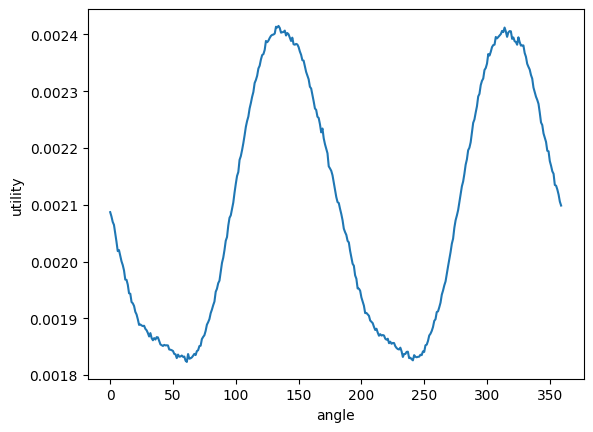

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(psi_mask.psi_grid, utility)
ax.set_xlabel('angle')
ax.set_ylabel('utility')

In [17]:
utility_diff = (utility - utility.min()) / (utility.max() - utility.min())

In [18]:
def arc_arrow(ax, start_angle=0., end_angle=np.pi/2, radius=1., arrow_size=0.05, color='k', lw=1.5, unit='degree', label=None):

    if unit == 'degree':
        start_angle = start_angle / 180. * np.pi
        end_angle = end_angle / 180. * np.pi
    base_angle = end_angle - arrow_size * np.sqrt(3) / radius
    
    # This draws the arc
    theta = np.linspace(start_angle, base_angle, 100)
    radii = radius * np.ones_like(theta)
    ax.plot(theta, radii, lw=lw, color=color, zorder=30, clip_on=False)
    
    # Calculate vertices for the arrow tip
    vertices = [(end_angle, radius), (base_angle, radius + arrow_size), (base_angle, radius - arrow_size)]

    arrow = plt.Polygon(vertices, closed=True, color=color)
    ax.add_patch(arrow)
    arrow.set_clip_on(False)
    arrow.set_zorder(30)
    
    # if label is not None:
    #     ax.text(start_angle - 5/180 * np.pi, radius, label, ha='left', va='bottom', fontsize=12)
    if label is not None:
        label_radius = radius - 2 * arrow_size
        label_angle = end_angle
        ax.text(label_angle, label_radius, label, 
                ha='left', va='top', 
                rotation=np.degrees(label_angle) - 90,
                rotation_mode='anchor',
                fontsize=12)

def rad_arrow(ax, angle=90., start_radius=1., end_radius=1.2, arrow_size=0.05, color='k', lw=1.5, unit='degree', label=None):

    if unit == 'degree':
        angle = angle / 180. * np.pi
    base_radius = end_radius - arrow_size * np.sqrt(3)
    
    # This draws the arc
    radii = np.linspace(start_radius, base_radius, endpoint=True)
    theta = angle * np.ones_like(radii)
    ax.plot(theta, radii, lw=lw, color=color, zorder=30, clip_on=False)
    

    # Calculate vertices for the arrow tip
    vertices = [(angle - arrow_size/base_radius, base_radius), (angle, base_radius + arrow_size), (angle+arrow_size/base_radius, base_radius)]

    arrow = plt.Polygon(vertices, closed=True, color=color)
    ax.add_patch(arrow)
    arrow.set_clip_on(False)
    arrow.set_zorder(30)
    
    # if label is not None:
    #     ax.text(start_angle - 5/180 * np.pi, radius, label, ha='left', va='bottom', fontsize=12)
    if label is not None:
        label_radius = end_radius
        label_angle = angle - 2 * arrow_size / label_radius
        ax.text(label_angle, label_radius, label, 
                ha='left', va='top', 
                rotation=np.degrees(angle) - 90,
                rotation_mode='anchor',
                fontsize=12)

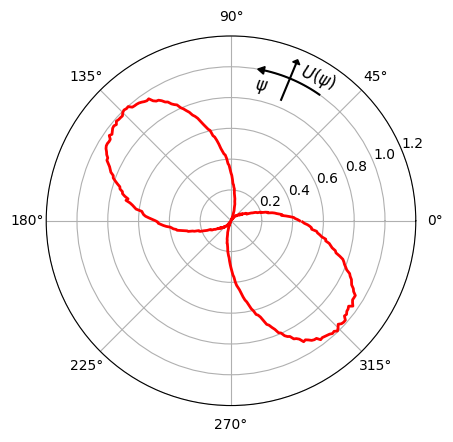

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Create a figure and an axis with a polar projection
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot data on the polar axis
ax.plot(psi_mask.psi_grid / 360 * 2 * np.pi, utility_diff, color='r', linewidth=2)

arc_arrow(ax, start_angle=55, end_angle=80, radius=utility_diff.max() * 1, arrow_size=0.025, label='$\psi$')

rad_arrow(ax, angle=135/2, start_radius=utility_diff.max() * 0.85, end_radius=utility_diff.max() * 1.15, arrow_size=0.025, label='$U(\psi)$')

ax.set_rlim([0, 1.2])

# Display the figure
plt.show()


In [20]:
from sklearn.model_selection import train_test_split

spec_dataset = SpectrumDataset(
    '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt',
    num_wq=50
    )

train_idx, val_test_idx = train_test_split(np.arange(len(spec_dataset)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)


In [93]:
idx_plot = 10
param_test = data['params'][train_idx[idx_plot]]

In [22]:
w_grid = data['w_grid']
q_grid = data['q_grid']
Syy_grid = data['Syy']
Szz_grid = data['Szz']

exp = SimulatedExperiment(q_grid, w_grid, Syy_grid[train_idx[idx_plot]], Szz_grid[train_idx[idx_plot]])

In [23]:
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.psimask import downsample_1d_with_map_coordinates

In [24]:
measurement = calc_Sqw_from_Syy_Szz(psi_mask.hklw_grid, exp.Syy_func, exp.Szz_func)

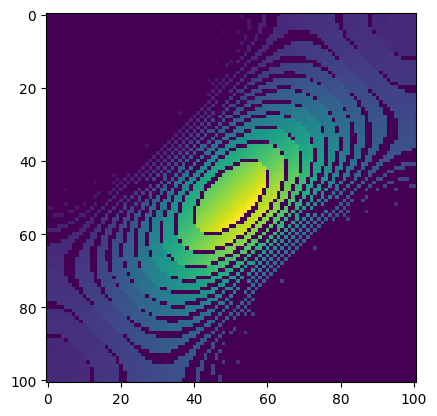

In [25]:
plt.imshow(Szz_grid[0,100].reshape(101,101))

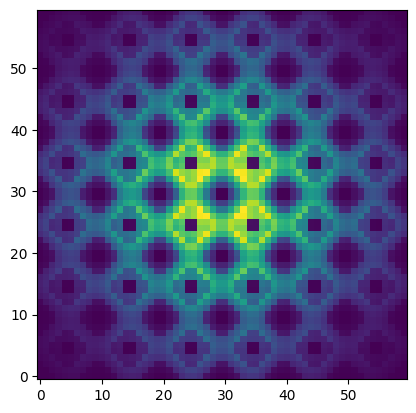

In [26]:
fig, ax = plt.subplots(1,1)
ax.imshow(measurement.sum(axis=-1).sum(axis=-1), origin='lower', aspect='auto')
ax.set_aspect('equal')

In [27]:
# _mask = psi_mask.get_mask(1)

# dist_list = []
# model.to(device)
# with torch.no_grad():
#     for param in tqdm(particle.positions.T):
#         x, l = psi_mask.get_model_input(param, grid='hklw')
#         output = model(x[_mask].to(device), l[_mask].to(device)).cpu()
#         dist_list.append((output.squeeze() - measurement[_mask]).norm().item())

In [94]:
model.to('cpu')
x, l = psi_mask.get_model_input(param_test, grid='hklw')
print(x[...,0].max())
_x = x[...,:3].clone().numpy()
print(x[...,0].max())
_x[...,:2] = np.abs(x.numpy()[...,:2] - np.round(x.numpy()[...,:2]))
print(x[...,0].max())
Syy_chck = torch.from_numpy(exp.Syy_func(_x))
Szz_chck = torch.from_numpy(exp.Szz_func(_x))

tensor(2.9500, dtype=torch.float64)
tensor(2.9500, dtype=torch.float64)
tensor(2.9500, dtype=torch.float64)


In [95]:
xx = torch.cat(
    [
        torch.from_numpy(_x),
        torch.zeros(_x.shape[:-1] + (2,))
    ], dim=-1
)
xx = xx[...,0,0,:]
xx[...,-2:] = param_test
model.cpu()
with torch.no_grad():
    xx = model.prepare_input(xx)
    Syy_network = model.Syy_net(xx.cpu().to(model.dtype)).cpu()
    Szz_network = model.Szz_net(xx.cpu().to(model.dtype)).cpu()

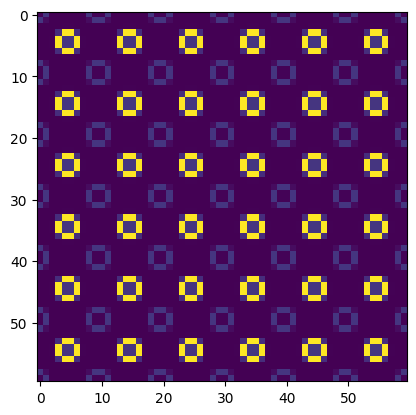

In [97]:
plt.imshow(Syy_chck[...,0,0])

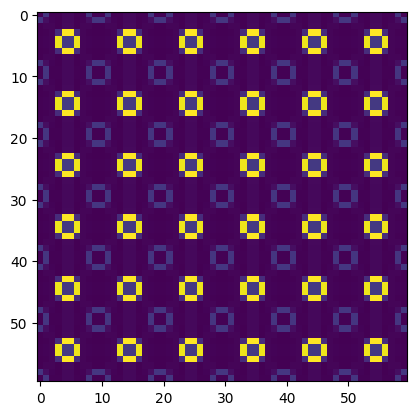

In [98]:
plt.imshow(Syy_network)

In [112]:
with torch.no_grad():
    output_full = model(
        x[...,0,10,:].cpu(), 
        l[...,0,10,:].cpu(),
    ).cpu().reshape(input.shape[:2])
    # output_full = model(
    #     x[...,0,0,:].cpu(), 
    #     l[...,0,0,:].cpu(),
    #     Syy = Syy_chck[...,0,10],
    #     Szz = Szz_chck[...,0,10]
    # ).cpu().reshape(input.shape[:2])
    # output_chck = model.calculate_Sqw(torch.cat((x[...,:2], l, x[...,[2]]), dim=-1).view(-1,4), Syy_chck.view(-1), Szz_chck.view(-1)).view(x.shape[:-1])

In [196]:
# model.calculate_Sqw(torch.cat((x[...,:2], l, x[...,[2]]), dim=-1).view(-1,4), Syy_chck.view(-1), Szz_chck.view(-1)).view(x.shape[:-1])

In [259]:
# plt.imshow(calc_Sqw_from_Syy_Szz(psi_mask.hklw_grid[...,0,10,:], exp.Syy_func, exp.Szz_func))
# plt.imshow(calc_Sqw_from_Syy_Szz(torch.cat((x[...,0,10,:2], l[...,0,10,:], x[...,0,10,[2]]), dim=-1), exp.Syy_func, exp.Szz_func))

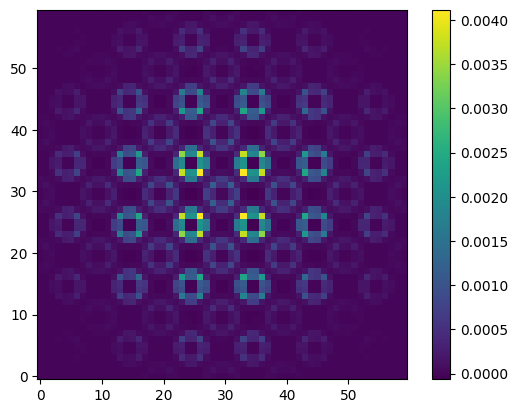

In [113]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(output_full, origin='lower', aspect='auto')
# im = ax.imshow(output_chck[...,0,10], origin='lower', aspect='auto')
ax.set_aspect('equal')
fig.colorbar(im)

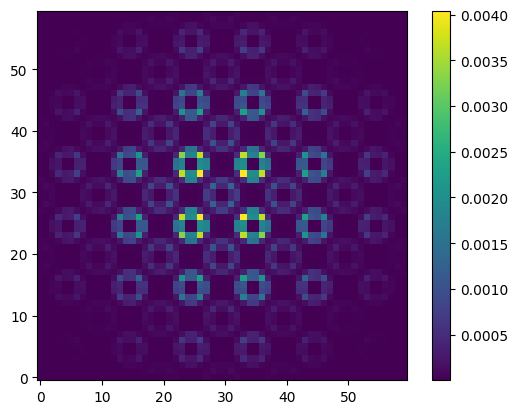

In [114]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(measurement[...,0,10], origin='lower', aspect='auto')
ax.set_aspect('equal')
fig.colorbar(im)

In [56]:
x.shape

torch.Size([150, 100, 5])

In [55]:
from inxss import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.15,0.3],[0.5,0.5],[0,0]], 100))
wpts = spec_dataset.data_dict['w_grid']

x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
x[...,:3] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=-1)
x[...,3:] = param_test

S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()

In [52]:
S_true_func = RegularGridInterpolator(
    (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
    spec_dataset.data_dict['S'][train_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
S_true = S_true_func(x.detach().numpy()[...,:3])

# S_true = calc_Sqw_from_Syy_Szz(_x, exp.Syy_func, exp.Szz_func)

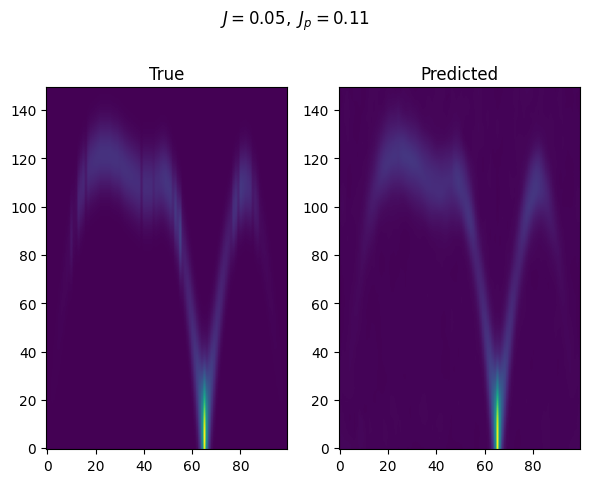

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(S_true, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={param_test[0]:.2f}, \ J_{{p}}={param_test[1]:.2f}$')
fig.tight_layout()